In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def db_query(
    db: str, min_dec: float, max_dec: float, min_ra: float, max_ra: float
) -> pd.DataFrame:
    """
    Queries a federated database for astronomical data within a specified range of declination and right ascension.

    Args:
        db (str): The path to the SQLite database file.
        min_dec (float): The minimum declination value to query.
        max_dec (float): The maximum declination value to query.
        min_ra (float): The minimum right ascension value to query.
        max_ra (float): The maximum right ascension value to query.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the queried astronomical data.
    """

    conn = sqlite3.connect(db)

    # Determine the relevant shard(s) based on the query parameters.
    arr = np.arange(np.floor(min_dec), np.ceil(max_dec) + 1, 1)
    relevant_shard_ids = set()
    for i in range(len(arr) - 1):
        shard_id = f"{arr[i]:.0f}_{arr[i + 1]:.0f}"
        relevant_shard_ids.add(shard_id)

    # Execute the federated query across the relevant shard(s).
    df_total = pd.DataFrame()
    for shard_id in relevant_shard_ids:
        shard_table_name = f"{shard_id}"
        q = f"SELECT * FROM `{shard_table_name}` WHERE dec BETWEEN {min_dec} AND {max_dec} AND ra BETWEEN {min_ra} AND {max_ra}"
        df = pd.read_sql_query(q, conn)
        df_total = pd.concat([df, df_total], axis=0)

    # Close the conn and return the results.
    conn.close()
    return df_total.sort_values(by=["j_m"]).reset_index(drop=True)

In [3]:
%%time
df = db_query("./db/gaia_tmass_6_jm_cut.db", -90, 90, 0, 360)

CPU times: user 125 ms, sys: 14.6 ms, total: 140 ms
Wall time: 163 ms


In [4]:
df

,ra,dec,pmra,pmdec,phot_g_mean_mag,j_m
0,69.189343,-62.077480,,,7.623046,-2.652
1,207.258088,-28.367905,-51.772716,-59.688094,5.914568,-1.737
2,202.427998,-23.281270,-46.659632,7.98415,6.179209,-1.314
3,108.385306,-44.638319,109.48482,323.504434,9.820806,-1.063
4,247.160789,41.881651,29.428787,-2.008518,2.649676,-0.955
...,...,...,...,...,...,...
57838,335.068155,-12.221610,48.506844,-12.111183,7.515577,5.999
57839,305.968870,-60.609645,-0.340164,-17.263402,7.642575,5.999
57840,308.091295,46.036691,2.410939,-5.08551,8.415009,5.999
57841,325.999487,45.985915,-3.503895,-3.968219,10.265462,5.999


Text(0.5, 1.0, 'Mollweide Projection of Astronomical Data')

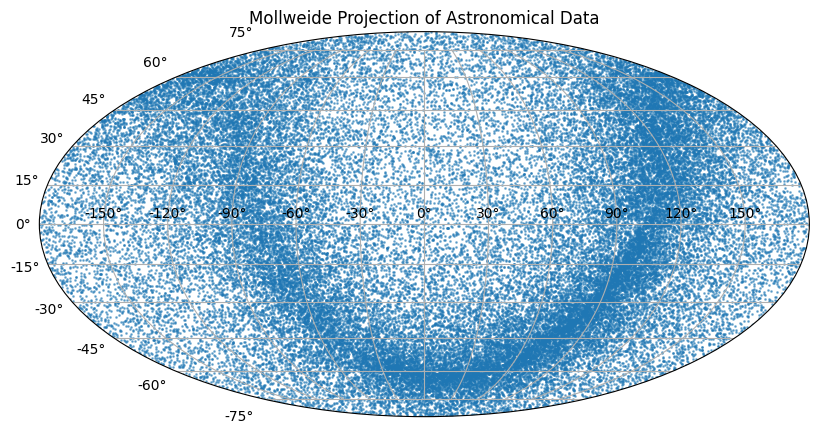

In [5]:
# plot mollweide projection of ra, dec
plt.figure(figsize=(10, 5))
plt.subplot(111, projection="mollweide")
plt.scatter(
    np.radians(df["ra"].values - 180), np.radians(df["dec"].values), s=1, alpha=0.5
)
plt.grid(True)
plt.title("Mollweide Projection of Astronomical Data")

In [6]:
# big db
path = "/Users/peter/astra/gaia_tmass_16_jm_cut.db"

# get every table name
conn = sqlite3.connect(path)
q = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(q, conn)
conn.close()
tables

,name
0,-90_-89
1,-89_-88
2,-88_-87
3,-87_-86
4,-86_-85
...,...
175,86_87
176,87_88
177,88_89
178,89_90


In [7]:
# create a matching db as big db with same tables but empty,
# then copy each table but only with rows where j_m < cutoff,
# so we can have a smaller db to test with


def many_tables(old_db_path: str, new_db_path: str, cutoff: float):
    """
    Creates a new SQLite database by copying tables from an existing database,
    filtering rows based on a specified cutoff value for the 'j_m' column.

    Args:
        old_db_path (str): The path to the original SQLite database file.
        new_db_path (str): The path to the new SQLite database file to be created.
        cutoff (float): The cutoff value for filtering rows in the 'j_m' column.
    """

    # Connect to the original database and fetch table names.
    conn = sqlite3.connect(old_db_path)
    q = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(q, conn)
    conn.close()
    tables_list = tables["name"].tolist()
    tables_list.sort()

    # Create a new database and copy filtered tables.
    conn_new = sqlite3.connect(new_db_path)
    for table in tables_list:
        print(f"Processing table: {table}")
        # Create an empty table in the new database with the same schema.
        conn_old = sqlite3.connect(path)
        q_schema = (
            f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table}';"
        )
        schema_df = pd.read_sql_query(q_schema, conn_old)
        create_table_sql = schema_df.iloc[0, 0]
        conn_old.close()
        try:
            conn_new.execute(create_table_sql)
        except sqlite3.OperationalError as e:
            print(f"Error creating table {table}: {e}")
            continue

        # Copy rows where 'j_m' is less than the cutoff value.
        conn_old = sqlite3.connect(path)
        q_data = f"SELECT * FROM `{table}` WHERE j_m < {cutoff};"
        df_filtered = pd.read_sql_query(q_data, conn_old)
        conn_old.close()
        df_filtered.to_sql(table, conn_new, if_exists="append", index=False)

    # Close the connection to the new database.
    conn_new.close()

In [10]:
for i in range(15, 15 + 1):
    many_tables(
        "/Users/peter/astra/gaia_tmass_16_jm_cut.db",
        f"./db/gaia_tmass_{i}_jm_cut.db",
        i,
    )

Processing table: -10_-9
Processing table: -11_-10
Processing table: -12_-11
Processing table: -13_-12
Processing table: -14_-13
Processing table: -15_-14
Processing table: -16_-15
Processing table: -17_-16
Processing table: -18_-17
Processing table: -19_-18
Processing table: -1_0
Processing table: -20_-19
Processing table: -21_-20
Processing table: -22_-21
Processing table: -23_-22
Processing table: -24_-23
Processing table: -25_-24
Processing table: -26_-25
Processing table: -27_-26
Processing table: -28_-27
Processing table: -29_-28
Processing table: -2_-1
Processing table: -30_-29
Processing table: -31_-30
Processing table: -32_-31
Processing table: -33_-32
Processing table: -34_-33
Processing table: -35_-34
Processing table: -36_-35
Processing table: -37_-36
Processing table: -38_-37
Processing table: -39_-38
Processing table: -3_-2
Processing table: -40_-39
Processing table: -41_-40
Processing table: -42_-41
Processing table: -43_-42
Processing table: -44_-43
Processing table: -4

In [ ]:
# count total rows in each of the new dbs
for i in range(1, 15 + 1):
    name = f"./db/gaia_tmass_{i}_jm_cut.db"
    con = sqlite3.connect(name)
    cur = con.cursor()

    cur.execute("""
        SELECT name
        FROM sqlite_master
        WHERE type='table'
        AND name NOT LIKE 'sqlite_%'
    """)

    total = 0
    for (table,) in cur.fetchall():
        cur.execute(f'SELECT COUNT(*) FROM "{table}"')
        total += cur.fetchone()[0]

    print(i, total)


1 144
2 650
3 2132
4 6261
5 17963
6 57843
7 160302
8 426395
9 1097624
10 2832488
11 6959162
12 16148536
13 36148731
14 79223584
15 160552109


In [ ]:
# count total rows in the 16 jm cut db
con = sqlite3.connect("/Users/peter/astra/gaia_tmass_16_jm_cut.db")
cur = con.cursor()

cur.execute("""
    SELECT name
    FROM sqlite_master
    WHERE type='table'
    AND name NOT LIKE 'sqlite_%'
""")

total = 0
for (table,) in cur.fetchall():
    cur.execute(f'SELECT COUNT(*) FROM "{table}"')
    total += cur.fetchone()[0]

print(16, total)

16 296899072
